In [23]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
import pyBigWig as pbw
from scipy import stats
import seaborn

In [4]:
%%bash

#randomly shuffle BED segments, but keep them on the same chromosome and do not allow overlaps
bedtools shuffle -chrom -noOverlapping -seed 252 -i ./all_peaks.ce10.bed -g ATAC_sequencing/2018_worm_atac/ref_data/WS220_chromInfo.txt > ./all_peaks.ce10.shuffled.bed

In [4]:
peak_coords = pandas.read_csv('./all_peaks.ce10.bed', sep='\t', names=['chrom', 'start', 'stop', 'name', 'score'])
print(peak_coords.shape)

shuf_coords = pandas.read_csv('./all_peaks.ce10.shuffled.bed', sep='\t', names=['chrom', 'start', 'stop', 'name', 'score'])
print(shuf_coords.shape)

(38017, 5)
(38017, 5)


## Analyze Janes, et al. 2018 ChIP-seq bigwigs

In [2]:
chip_seq_paths = sorted(glob.glob('./janes2018_chip-seq/*.bw'))
chip_seq_path_dict = {}
for path in chip_seq_paths:
    base_split = os.path.splitext(os.path.basename(path))[0].split('_')
    try:
        chip_seq_path_dict[base_split[3]][base_split[1]] = path
    except KeyError:
        chip_seq_path_dict[base_split[3]] = {base_split[1]:path}

In [35]:
print(list(chip_seq_path_dict['l2'].items()))

[('H3K27me3', './janes2018_chip-seq/GSE114440_H3K27me3_wt_l2.bw'), ('H3K36me3', './janes2018_chip-seq/GSE114440_H3K36me3_wt_l2.bw'), ('H3K4me1', './janes2018_chip-seq/GSE114440_H3K4me1_wt_l2.bw'), ('H3K4me3', './janes2018_chip-seq/GSE114440_H3K4me3_wt_l2.bw')]


In [39]:
with pbw.open('./janes2018_chip-seq/GSE114440_H3K4me1_wt_l2.bw') as bw_in:
    print(numpy.nan_to_num(numpy.array(bw_in.stats('chrI', 11302859, 11303483, exact=True))))

[None]


In [40]:
for mark, path in chip_seq_path_dict['l2'].items():
    print(mark)
    with pbw.open(path) as bw_in:
        chrom_means = {k:numpy.nan_to_num(bw_in.stats(k, 0, v))[0] for k,v in bw_in.chroms().items()}
        peak_coords['janes_{!s}_mean'.format(mark)] = [elt if elt is not None else 0 for elt in 
                                                       [numpy.nan_to_num(bw_in.stats(peak_coords.loc[idx, 'chrom'], 
                                                                         peak_coords.loc[idx, 'start'],
                                                                         peak_coords.loc[idx, 'stop'], exact=True))[0]
                                                        for idx in range(peak_coords.shape[0])]]
        peak_coords['janes_{!s}_chrom_mean'.format(mark)] = [chrom_means[elt] for elt in peak_coords['chrom'].to_numpy()]
        shuf_coords['janes_{!s}_mean'.format(mark)] = [elt if elt is not None else 0 for elt in 
                                                       [numpy.nan_to_num(bw_in.stats(shuf_coords.loc[idx, 'chrom'], 
                                                                         shuf_coords.loc[idx, 'start'],
                                                                         shuf_coords.loc[idx, 'stop'], exact=True))[0]
                                                        for idx in range(shuf_coords.shape[0])]]
        shuf_coords['janes_{!s}_chrom_mean'.format(mark)] = [chrom_means[elt] for elt in shuf_coords['chrom'].to_numpy()]
print(peak_coords.shape)
peak_coords.head()

H3K27me3
H3K36me3
H3K4me1
H3K4me3
(38017, 18)


,chrom,start,stop,name,score,janes_H3K27me3_mean,janes_H3K27me3_chrom_mean,janes_H3K36me3_mean,janes_H3K36me3_chrom_mean,janes_H3K4me1_mean,janes_H3K4me1_chrom_mean,janes_H3K4me3_mean,janes_H3K4me3_chrom_mean,janes_H3K4me3_log2,janes_H3K27me3_log2,janes_H3K36me3_log2,janes_H3K4me1_log2,shuffled
0,chrI,3328,4211,peak2,1904.209526,-0.824468,-0.213828,-0.271050,0.153739,1.470828,0.134277,1.755626,0.310139,0.517339,-0.587702,-0.462546,0.435142,False
1,chrI,4233,4548,peak3,0.000000,-0.823055,-0.213828,0.070304,0.153739,1.817670,0.134277,2.473857,0.310139,0.718634,-0.586023,-0.079898,0.529472,False
2,chrI,10923,11895,peak6a,306.134972,-0.208915,-0.213828,-0.284752,0.153739,0.368592,0.134277,0.810488,0.310139,0.200752,0.003878,-0.480243,0.086401,False
3,chrI,11896,12053,peak6b,0.000000,-0.473685,-0.213828,-0.239977,0.153739,0.678105,0.134277,1.590916,0.310139,0.466931,-0.221603,-0.423200,0.193132,False
4,chrI,12244,12700,peak7a,0.000000,-0.261322,-0.213828,-0.235180,0.153739,0.360625,0.134277,1.291209,0.310139,0.370429,-0.038042,-0.417219,0.083546,False


In [41]:
adj = abs(numpy.min(peak_coords[['janes_H3K4me3_mean', 'janes_H3K4me3_chrom_mean']].to_numpy())) + 1
peak_coords['janes_H3K4me3_log2'] = numpy.log2((peak_coords['janes_H3K4me3_mean'] + adj)
                                               /(peak_coords['janes_H3K4me3_chrom_mean'] + adj))
adj = abs(numpy.min(peak_coords[['janes_H3K27me3_mean', 'janes_H3K27me3_chrom_mean']].to_numpy())) + 1
peak_coords['janes_H3K27me3_log2'] = numpy.log2((peak_coords['janes_H3K27me3_mean'] + adj)
                                                /(peak_coords['janes_H3K27me3_chrom_mean'] + adj))
adj = abs(numpy.min(peak_coords[['janes_H3K36me3_mean', 'janes_H3K36me3_chrom_mean']].to_numpy())) + 1
peak_coords['janes_H3K36me3_log2'] = numpy.log2((peak_coords['janes_H3K36me3_mean'] + adj)
                                                /(peak_coords['janes_H3K36me3_chrom_mean'] + adj))
adj = abs(numpy.min(peak_coords[['janes_H3K4me1_mean', 'janes_H3K4me1_chrom_mean']].to_numpy())) + 1
peak_coords['janes_H3K4me1_log2'] = numpy.log2((peak_coords['janes_H3K4me1_mean'] + adj)
                                               /(peak_coords['janes_H3K4me1_chrom_mean'] + adj))

In [42]:
print(adj)

3.662271558245023


In [43]:
adj = abs(numpy.min(numpy.nan_to_num(shuf_coords[['janes_H3K4me3_mean', 'janes_H3K4me3_chrom_mean']].to_numpy()))) + 1
shuf_coords['janes_H3K4me3_log2'] = numpy.log2((shuf_coords['janes_H3K4me3_mean'] + adj)
                                               /(shuf_coords['janes_H3K4me3_chrom_mean'] + adj))
adj = abs(numpy.min(numpy.nan_to_num(shuf_coords[['janes_H3K27me3_mean', 'janes_H3K27me3_chrom_mean']].to_numpy()))) + 1
shuf_coords['janes_H3K27me3_log2'] = numpy.log2((shuf_coords['janes_H3K27me3_mean'] + adj)
                                                /(shuf_coords['janes_H3K27me3_chrom_mean'] + adj))
adj = abs(numpy.min(numpy.nan_to_num(shuf_coords[['janes_H3K36me3_mean', 'janes_H3K36me3_chrom_mean']].to_numpy()))) + 1
shuf_coords['janes_H3K36me3_log2'] = numpy.log2((shuf_coords['janes_H3K36me3_mean'] + adj)
                                                /(shuf_coords['janes_H3K36me3_chrom_mean'] + adj))
adj = abs(numpy.min(numpy.nan_to_num(shuf_coords[['janes_H3K4me1_mean', 'janes_H3K4me1_chrom_mean']].to_numpy()))) + 1
shuf_coords['janes_H3K4me1_log2'] = numpy.log2((shuf_coords['janes_H3K4me1_mean'] + adj)
                                               /(shuf_coords['janes_H3K4me1_chrom_mean'] + adj))

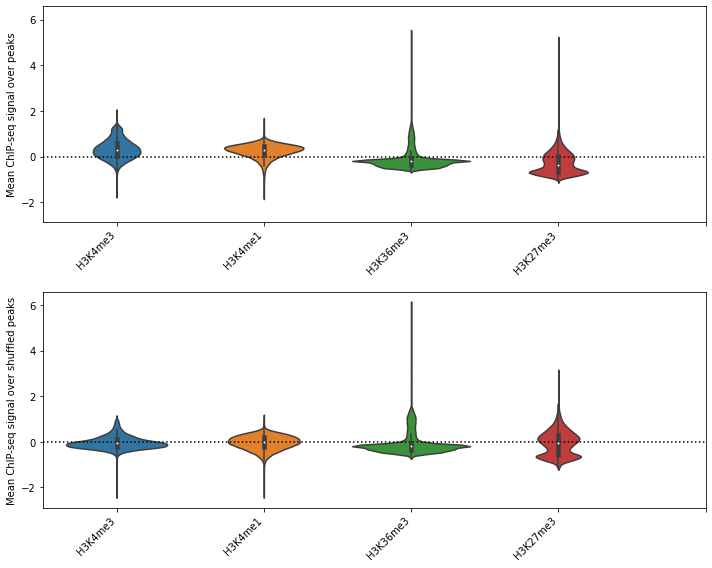

In [44]:
fig, axes = pyplot.subplots(nrows=2, ncols=1, figsize=(10,8), sharey=True)
axes[0].axhline(0, linestyle='dotted', color='k')
seaborn.violinplot(data=peak_coords[['janes_H3K4me3_log2', 'janes_H3K4me1_log2', 
                                     'janes_H3K36me3_log2', 'janes_H3K27me3_log2']], ax=axes[0])
#seaborn.violinplot(x=0, y=peak_coords['h3k4me3_mean'], ax=axes[0])
#seaborn.violinplot(x=1, y=peak_coords['h3k4me1_mean'], ax=axes[0])
#seaborn.violinplot(x=2, y=peak_coords['h3k27ac_mean'], ax=axes[0])
#seaborn.violinplot(x=3, y=peak_coords['h3k27me3_mean'], ax=axes[0])
#seaborn.violinplot(x=4, y=peak_coords['h3k9me3_mean'], ax=axes[0])
axes[0].set_ylabel('Mean ChIP-seq signal over peaks')
axes[0].set_xticks(numpy.arange(5))
axes[0].set_xticklabels(['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'], ha='right', rotation=45)

axes[1].axhline(0, linestyle='dotted', color='k')
seaborn.violinplot(data=shuf_coords[['janes_H3K4me3_log2', 'janes_H3K4me1_log2', 
                                     'janes_H3K36me3_log2', 'janes_H3K27me3_log2']], ax=axes[1])
#seaborn.violinplot(x=0, y=shuf_coords['h3k4me3_mean'], ax=axes[1])
#seaborn.violinplot(x=1, y=shuf_coords['h3k4me1_mean'], ax=axes[1])
#seaborn.violinplot(x=2, y=shuf_coords['h3k27ac_mean'], ax=axes[1])
#seaborn.violinplot(x=3, y=shuf_coords['h3k27me3_mean'], ax=axes[1])
#seaborn.violinplot(x=4, y=shuf_coords['h3k9me3_mean'], ax=axes[1])
axes[1].set_ylabel('Mean ChIP-seq signal over shuffled peaks')
axes[1].set_xticks(numpy.arange(5))
axes[1].set_xticklabels(['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'], ha='right', rotation=45)

fig.tight_layout()

In [45]:
to_plot.head()

,name,shuffled,variable,value
0,peak2,False,janes_H3K4me3_log2,0.517339
1,peak3,False,janes_H3K4me3_log2,0.718634
2,peak6a,False,janes_H3K4me3_log2,0.200752
3,peak6b,False,janes_H3K4me3_log2,0.466931
4,peak7a,False,janes_H3K4me3_log2,0.370429


In [12]:
to_plot.melt(id_vars=['name', 'shuffled'], 
             value_vars=['janes_H3K4me3_log2', 'janes_H3K4me1_log2', 
                         'janes_H3K36me3_log2', 'janes_H3K27me3_log2']).head()

,name,shuffled,variable,value
0,peak2,False,janes_H3K4me3_log2,0.517339
1,peak3,False,janes_H3K4me3_log2,0.718634
2,peak6a,False,janes_H3K4me3_log2,0.200752
3,peak6b,False,janes_H3K4me3_log2,0.466931
4,peak7a,False,janes_H3K4me3_log2,0.370429


In [26]:
to_plot[to_plot['value'].isnull()].head()

,name,shuffled,variable,value
38116,peak164b,True,janes_H3K4me3_log2,NaN
38210,peak301,True,janes_H3K4me3_log2,NaN
38259,peak385,True,janes_H3K4me3_log2,NaN
38377,peak533,True,janes_H3K4me3_log2,NaN
38585,peak820,True,janes_H3K4me3_log2,NaN


In [47]:
shuf_coords[shuf_coords['janes_H3K4me3_log2'].isnull()].head()

,chrom,start,stop,name,score,janes_H3K27me3_mean,janes_H3K27me3_chrom_mean,janes_H3K36me3_mean,janes_H3K36me3_chrom_mean,janes_H3K4me1_mean,janes_H3K4me1_chrom_mean,janes_H3K4me3_mean,janes_H3K4me3_chrom_mean,janes_H3K4me3_log2,janes_H3K27me3_log2,janes_H3K36me3_log2,janes_H3K4me1_log2,shuffled


janes_H3K4me3_log2 -137.24872846073333 0.0
janes_H3K4me1_log2 -131.63646768015568 0.0
janes_H3K36me3_log2 17.480400512538356 2.7606266871584307e-68
janes_H3K27me3_log2 62.46618318992675 0.0


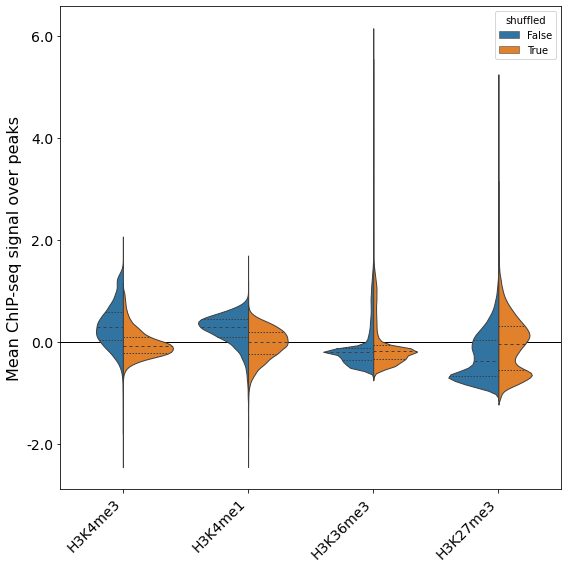

In [49]:
peak_coords['shuffled'] = False
shuf_coords['shuffled'] = True
cols_to_plot = ['janes_H3K4me3_log2', 'janes_H3K4me1_log2', 'janes_H3K36me3_log2', 'janes_H3K27me3_log2']
to_plot = pandas.concat([peak_coords, shuf_coords]).melt(id_vars=['name', 'shuffled'],
                                                         value_vars=cols_to_plot)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,8), sharey=True)
seaborn.violinplot(data=to_plot, x='variable', y='value',
                   hue='shuffled', order=cols_to_plot, split=True, inner='quart', linewidth=1, ax=axes)
#axes.axhline(0, linestyle='dotted', color='k')
axes.axhline(0, linewidth=1, color='k', zorder=-5)
axes.set_ylabel('Mean ChIP-seq signal over peaks', fontsize=16)
axes.set_yticklabels(axes.get_yticks(), fontsize=14)
axes.set_xticks(numpy.arange(4))
axes.set_xticklabels(['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'], ha='right', rotation=45, fontsize=14)
axes.set_xlabel('')

for idx, col_val in enumerate(cols_to_plot):
    (t_stat, pval) = stats.ttest_ind(to_plot[(to_plot['variable'] == col_val) & to_plot['shuffled']]['value'], 
                                     to_plot[(to_plot['variable'] == col_val) & ~to_plot['shuffled']]['value'], 
                                     equal_var=False)
    print(col_val, t_stat, pval)
#    if pval < 0.0001:
#        axes.text(idx, to_plot['value'].max(), '****', fontsize=12, color='k')
#    elif pval < 0.001:
#        axes.text(idx, to_plot['value'].max(), '***', fontsize=12, color='k')
#    elif pval < 0.01:
#        axes.text(idx, to_plot['value'].max(), '**', fontsize=12, color='k')
#    elif pval < 0.05:
#        axes.text(idx, to_plot['value'].max(), '*', fontsize=12, color='k')

fig.savefig('./chromatin_mark_comparison.pdf', bbox_inches='tight')
fig.tight_layout()